# Neural Networks for Data Science Applications
## Homework 1: Customized activation functions

**Name**: *`Livia Oddi`*

**Matricola**: *`1846085`*

> ✍ Upload the completed notebook **before 20/11/2024 at 23:59** on the Google Classroom page.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**) and 1 optional exercise. The optional one is ungraded but I may take it into consideration for the final mark during the oral.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. Marks between 4 and 5 can be fully recovered during the oral examination.
3. If you want to improve the mark, you are also free to complete the full EoT homework to recover a full mark.
3. The grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (except where specified) while vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

### Introduction: Trainable activation functions

Remember that a trainable variant of the Swish function can be written as:

$$ \phi(s) = (as + b)\sigma(cs + d) $$

where $s$ is the scalar input of the AF, $\left\{a, b, c, d\right\}$ are four scalar parameters, and $\sigma$ is the sigmoid function. Note how this can be (roughly) interpreted as a one-hidden layer MLP with one input, one hidden unit, and one output. Thus, we can easily generalize this as:

$$ \phi(s) = \sum_{i=1}^n (a_is+b_i)\sigma(c_is+d_i) \tag{1} $$

where $n$ is an hyper-parameter, and the function has now $4n$ parameters $\left\{a_i, b_i, c_i, d_i\right\}_{i=1}^n$. By varying $n$ we can make the activation function as complicated as we want: we say this is a **non-parametric** AF [1]. The homework will guide you to implement an MLP exploiting (1) in JAX.

In [ ]:
import jax
import jax.numpy as jnp

### Exercise 1 (1 point)

We begin by implementing (1) (no MLPs for now) in JAX. Following what we saw in the first lab session, implement equation (1) in pure JAX (no external libraries) using a pair of (init, call) functions, respectively for initializing the parameters and for computing the outputs of the AF.

For the purpose of this exercise we consider a single AF with mini-batching over the input, hence the signature of the functions should be:

```
def init_fcn(key, n):
   # key is the PNRG state
   # n is the hyper-parameter in (1)
   # Returns: the parameters (a,b,c,d) in whatever format you prefer.
```


```
def call_fcn(params, x: Float[Array, "b"])
           -> Float[Array, "b"]:
   # x is a vector (mini-batch) of b inputs to the function
   # params is the output of init_fcn
   # Returns the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).
```






✅ **Completion requirement**: Show me the two functions work as expected. For example, you can plot some randomly-initialized functions for different choices of $n$.

In [ ]:
# TODO: implement Exercise 1.

#Necessary libraries
from functools import partial #for @partial
%pip install jaxtyping --quiet
from jaxtyping import Array, Float, Int
import matplotlib.pyplot as plt #For Visualization

def init_fcn(key, n):
  key1, key2, key3, key4 = jax.random.split(key, 4)
  a = jax.random.normal(key1, (n,))
  b = jax.random.normal(key2, (n,))
  c = jax.random.normal(key3, (n,))
  d = jax.random.normal(key4, (n,))
  return a, b, c, d

def call_fcn(params, x: Float[Array, "b"]) -> Float[Array, "b"]:
  a, b, c, d = params
  phi = jnp.sum((a[:, None] * x + b[:, None]) * jax.nn.sigmoid(c[:, None] * x + d[:, None]), axis = 0)
  return phi

Now, to check if the function is actually doing what it is supposed to do, we can try it with a random input:

In [ ]:
key = jax.random.PRNGKey(0) #starting state of the random number generator
b = 10  #batch size
n = 5   #dimension of each input

key, subkey = jax.random.split(key)
x = jax.random.normal(key, (b,))
params = init_fcn(key, n)

output = call_fcn(params, x)
print(output)

[-2.7183409 -2.5788493 -4.129329  -2.0137239 -3.1627622 -4.086955
 -3.2396336 -2.560207  -2.8663893 -2.9094088]


> `call_fcn` , given that the batch size was set to 10, returns the expected output $\phi(x_1), \phi(x_2), \ldots, \phi(x_b)$.

We can also plot some randomly-initialized functions for different choices of  n to have a graphical representation of the `call_fcn`:

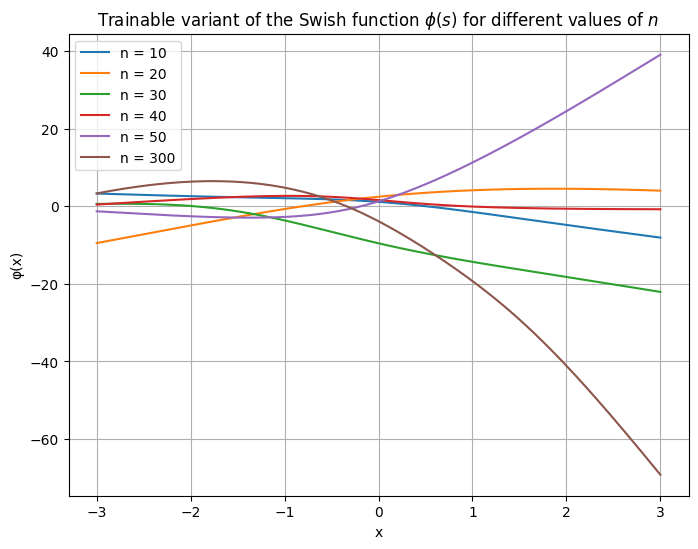

In [ ]:
x = jnp.linspace(-3, 3, 300)
key = jax.random.PRNGKey(0)

plt.figure(figsize=(8, 6))

# Different values of n
for n in [10, 20, 30, 40, 50, 300]:
    params = init_fcn(key, n)
    y = call_fcn(params, x)

    plt.plot(x, y, label=f'n = {n}')

plt.title("Trainable variant of the Swish function $\\phi(s)$ for different values of $n$")
plt.xlabel("x")
plt.ylabel("φ(x)")
plt.legend()
plt.grid()
plt.show()

> From the above plot we can observe that smaller n results in smoother and simpler curves, while larger n creates more complex and flexible transformations.<br> While higher n provides greater capacity to model non-linearities it might risk overfitting if the data is not sufficiently complex.

**References**
-  [jax.random.split(key, 4)](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html)

### Exercise 2 (1 point)

One issue of non-parametric AF is that they tend to work poorly when randomly-initialized. However, it is relatively easy to fix the parameters of (1) so that the initialized functions approximate any scalar function we desire (in fact, (1) for $n \rightarrow \infty$ is a universal approximator for 1D functions).

For this exercise, write a gradient descent procedure (again, pure JAX) that given $n$ finds the optimal coefficients $\left\{a_i, b_i, c_i, d_i\right\}$ such that:

$$ \phi(s) \approx \text{ReLU}(s) $$

Note that all functions from Exercise 1 and 2 should be scalar-valued apart from mini-batching.

✅ **Completion requirement**: Show me gradient descent converges correctly. For example, you can plot the quality of the approximation when increasing $n$.

In [ ]:
# TODO: complete Exercise 2.

#To do what we're asked we need to implement a function that minimizes the error between the output of phi(s) and the desired target function (ReLU)
#Since phi(s) represents a continuous scalar output approximating a target function like ReLU, MSE is a more appropriate loss than the cross-entropy

@jax.jit
@jax.value_and_grad
def swish_loss(params):  #computes both the loss and its gradient
    relu_approx = jax.nn.relu(x)
    swish_approx = call_fcn(params, x)
    return jnp.mean((swish_approx - relu_approx) ** 2)  #using MSE as the loss

#gradient descent procedure
params = init_fcn(key, n)
loss_history = []

for i in range(1000):
  l, g = swish_loss(params)
  loss_history.append(l)
  params = jax.tree.map(lambda p, grad_p: p - 0.01*grad_p, params, g)


We can check if the gradient descent procedure just written works with a visual representation of both the ***convergence of the gradient descent*** and the ***approximation of the Swish function*** for different values of n:

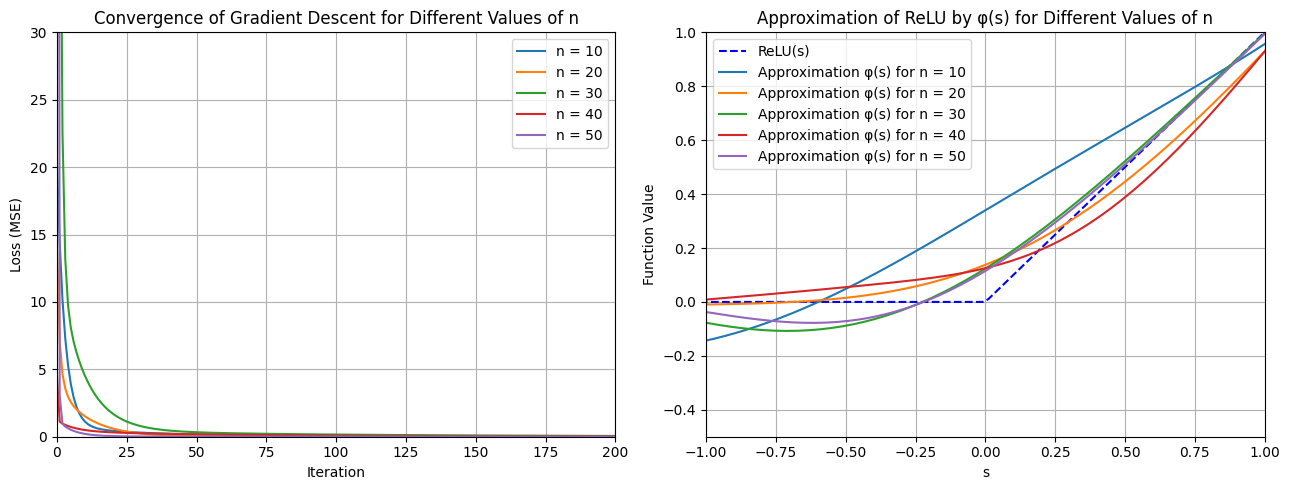

In [ ]:
b = 300  #batch size
key = jax.random.PRNGKey(0)
x = jnp.linspace(-3, 3, b)  #input values for approximation visualization
relu_vals = jax.nn.relu(x)  #ReLU function values


all_loss_histories = []
all_phi_vals = []

for n in [10, 20, 30, 40, 50]:
    params = init_fcn(key, n)
    loss_history = []

    #gradient descent
    for i in range(1000):
        loss, grads = swish_loss(params)
        loss_history.append(loss)
        params = jax.tree_util.tree_map(lambda p, g: p - 0.01 * g, params, grads)  # Update parameters

    all_loss_histories.append(loss_history)
    all_phi_vals.append(call_fcn(params, x))

#Visualization
plt.figure(figsize=(13, 5))

#Loss for each n
plt.subplot(1, 2, 1)
for n, loss_history in zip([10, 20, 30, 40, 50], all_loss_histories):
    plt.plot(loss_history, label=f'n = {n}')
plt.ylim(0, 30)
plt.xlim(0, 200)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Convergence of Gradient Descent for Different Values of n")
plt.legend()
plt.grid()

#Approximation of ReLU by φ(s) for each n
plt.subplot(1, 2, 2)
plt.plot(x, relu_vals, label="ReLU(s)", color="blue", linestyle="--")  #ReLU function
for n, phi_vals in zip([10, 20, 30, 40, 50], all_phi_vals):
    plt.plot(x, phi_vals, label=f'Approximation φ(s) for n = {n}')
plt.ylim(-0.5, 1)
plt.xlim(-1, 1)
plt.xlabel("s")
plt.ylabel("Function Value")
plt.title("Approximation of ReLU by φ(s) for Different Values of n")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


> The first plot shows that as the gradient descent proceeds, the loss (MSE) decreases fast for all n, converging near zero before 200 iterations, demonstrating effective optimization for different values of n.<br> For the second plot we can see that the more n grows the more the Swish approximation goes towards the ReLu, demonstrating that higher n improves the function's capacity to approximate the target.

**References**
- MSE instead of cross-entropy [MSE section](https://www.datacamp.com/tutorial/loss-function-in-machine-learning?utm_source=chatgpt.com)
- [ReLu in Jax](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.relu.html)

### Exercise 3 (1 point)

Clearly, a single activation function is not enough. For example, consider the following Sequential model in Keras:

```
model = Sequential([
  Dense(5),
  ReLU(),
  Dense(1)  
])
```
We would like to replace the intermediate ReLU layer with an equivalent layer implementing (1), where each unit (neuron) in the layer is assigned a different AF. Luckily, we can use `jax.vmap` over the result of Exercise 1 to solve this.

For this exercise, apply `vmap` over `call_fcn` to obtain the following variants:

1.   A single AF (shared parameters) for all the units of the layer.
2.   Different AFs (different parameters) for each unit in the layer.
3. (**Optional, more difficult**) A KAN-style AF [2] where a different AF is applied to each edge of a fully-connected layer.

The signature of all vmapped functions should be:

```
def vmapped_call_fcn(params, x: Float[Array, "b h"])
           -> Float[Array, "b h"]:
   ...
```
where $x$ is a generic output of a fully-connected layer, so that $h$ is the number of hidden units in the layer (e.g., $h=5$ for the first `Dense` layer above). For the new initialization functions, you are free to either rewrite them or find some way to vectorize the original one.

✅ **Completion requirement**: Show me the vectorization works as expected (e.g., generate and visualize multiple functions simultaneously).

In [ ]:
# TODO: complete Exercise 3.

#new initialization function
def init_fcn_new(key, b, h):
    key1, key2, key3, key4 = jax.random.split(key, 4)
    a = jax.random.normal(key1, (b,h))
    b_params = jax.random.normal(key2, (b,h))
    c = jax.random.normal(key3, (b,h))
    d = jax.random.normal(key4, (b,h))
    return a, b_params, c, d


#shared parameters for each neuron - output shape (b,h)
def vmapped_call_fcn_shared(params, x: Float[Array, "b h"]) -> Float[Array, "b h"]:
    return jax.vmap(call_fcn, in_axes=(None, 1), out_axes=1)(params, x)
# in_axes=(None, 1):
# -> None for params: shared parameters across all neurons and inputs.
# -> 1 for x: each input sample is processed independently with the shared parameters.

# different parameters for each neuron - output shape (b, h)
def vmapped_call_fcn_individual(params, x: Float[Array, "b h"]) -> Float[Array, "b h"]:
    return jax.vmap(call_fcn, in_axes=(1, 1), out_axes=1)(params, x)
# in_axes=(1, 1):
# -> 1 for params: each neuron gets its unique parameters.
# -> 1 for x: each input sample is processed independently across neurons.

Let's check some outputs to see if we implemented the functions correctly:

In [ ]:
key = jax.random.PRNGKey(0)
b = 5  #batch size
h = 3
n = 4
key, subkey = jax.random.split(key)

#batch of input:
x = jnp.linspace(-3, 3, b).reshape(b, 1)  #shape: (b, 1)
x = jnp.tile(x, (1, h))                  #shape: (b, h)

shared_params = init_fcn(key, n = 1) #shared parameter
single_AF = vmapped_call_fcn_shared(shared_params, x)

diff_params = init_fcn_new(key, n, h) #different parameters
diff_AF = vmapped_call_fcn_individual(diff_params, x)

print("Shared Parameters Output Shape:", single_AF.shape)
print("Shared Parameters Output:", single_AF)

print("Per-Neuron Output Shape:", diff_AF.shape)
print("Per-Neuron Output:", diff_AF)

Shared Parameters Output Shape: (5, 3)
Shared Parameters Output: [[-0.7395189  -0.7395189  -0.7395189 ]
 [ 0.13552809  0.13552809  0.13552809]
 [ 0.5838788   0.5838788   0.5838788 ]
 [ 0.6489864   0.6489864   0.6489864 ]
 [ 0.5165602   0.5165602   0.5165602 ]]
Per-Neuron Output Shape: (5, 3)
Per-Neuron Output: [[-1.4472128   9.393227    1.044424  ]
 [-0.0792768   4.579919    0.51100564]
 [ 0.55199575  0.39529917  0.25571546]
 [ 1.2957155  -2.0663784   0.44821644]
 [ 2.8010075  -3.2139688   0.96340746]]


> From this output we can see that the functions behave as expected: <br>
- The `vmapped_call_fcn_shared` results in identical activation values for all the neurons in the same batch (shared parameters across all neurons).
- The `vmapped_call_fcn_individual` gives different activation values for the neurons of the same batch (different parameters to each neuron).

For the completion requirement, we plot the behavior of shared and individual parameters across neurons:

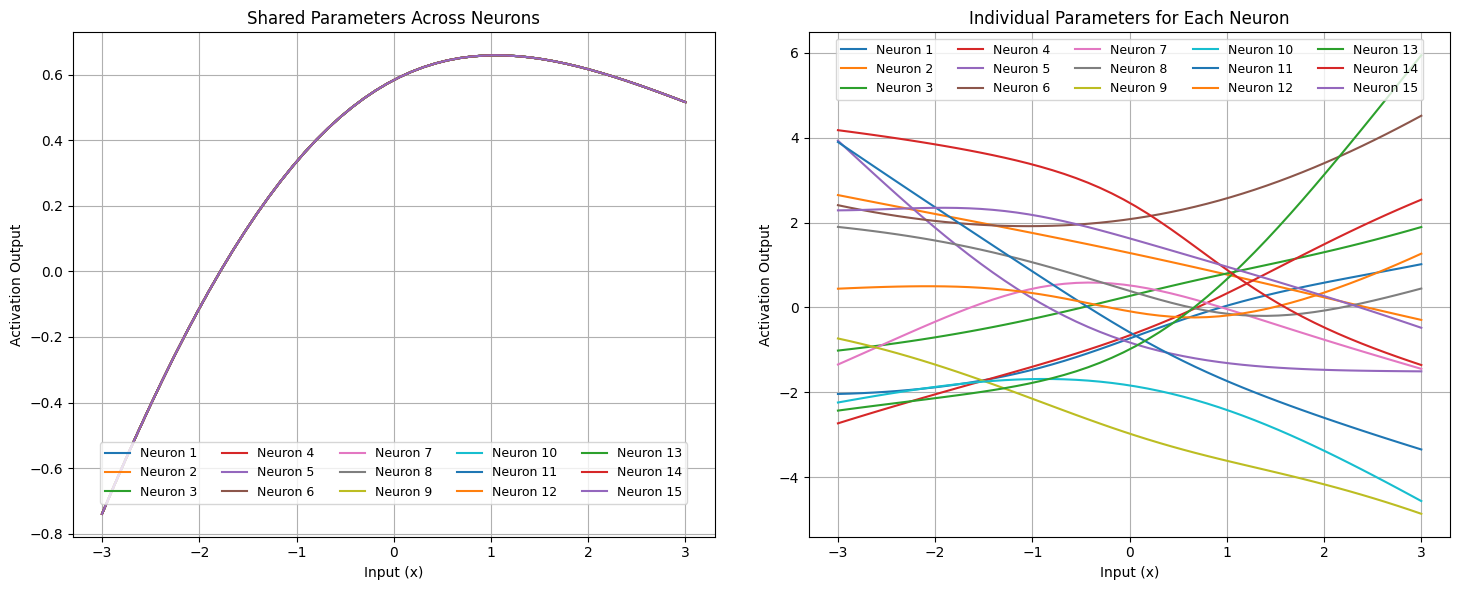

In [ ]:
key = jax.random.PRNGKey(0)
b = 50  # Batch size
h = 15
key, subkey = jax.random.split(key)
x = jnp.linspace(-3, 3, b).reshape(b, 1)  # Shape: (b, 1)
x = jnp.tile(x, (1, h))

shared_params = init_fcn(key, n = 1) #shared parameter
single_AF = vmapped_call_fcn_shared(shared_params, x)

diff_params = init_fcn_new(key, n, h) #different parameters
diff_AF = vmapped_call_fcn_individual(diff_params, x)

#Visualization
plt.figure(figsize=(15, 6))

#shared parameters
plt.subplot(1, 2, 1)
for i in range(single_AF.shape[1]):
    plt.plot(x[:, 0], single_AF[:, 0], label=f"Neuron {i+1}", linewidth=1.5)
plt.title("Shared Parameters Across Neurons")
plt.xlabel("Input (x)")
plt.ylabel("Activation Output")
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=5, fontsize=9, frameon=True
)
plt.grid()

#individual parameters
plt.subplot(1, 2, 2)
for i in range(diff_AF.shape[1]):
    plt.plot(x[:, i], diff_AF[:, i], label=f"Neuron {i+1}", linewidth=1.5)
plt.title("Individual Parameters for Each Neuron")
plt.xlabel("Input (x)")
plt.ylabel("Activation Output")
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, fontsize=9, frameon=True
)
plt.grid()

plt.tight_layout()
plt.show()

> We can see that all neurons produce identical activation outputs for the same input x, which proves that `vmapped_call_fcn_shared` works as it should. For the `vmapped_call_fcn_individual` we have different output for each neuron, which is again the exepected behaviour of the function.

### Exercise 4 (2 point)

It is now time to train an MLP with our new activation functions. To begin with, select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

The objective of the exercise is to train an MLP with one hidden layer having as activation functions (1). In order to do this you have multiple choices:

1. You can do this completely in JAX by defining a new pair of (init, call) functions describing the complete model and performing gradient descent with these.
2. If you want to use Keras (note: `.fit` is *not allowed*) as in the second lab session, you need to port the trainable function in Keras. My suggestion is to subclass the `Layer` object by wrapping the functions you have already created (https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The resulting layer will be backend-specific, which is not an issue. If you want something slightly harder, you can rewrite everything with Keras ops to make it backend-agnostic.
3. You can also use some high-level JAX library (e.g., Equinox, Haiku, ...). In this case, please document the code precisely.

✍ **DESCRIPTION OF THE DATASET**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

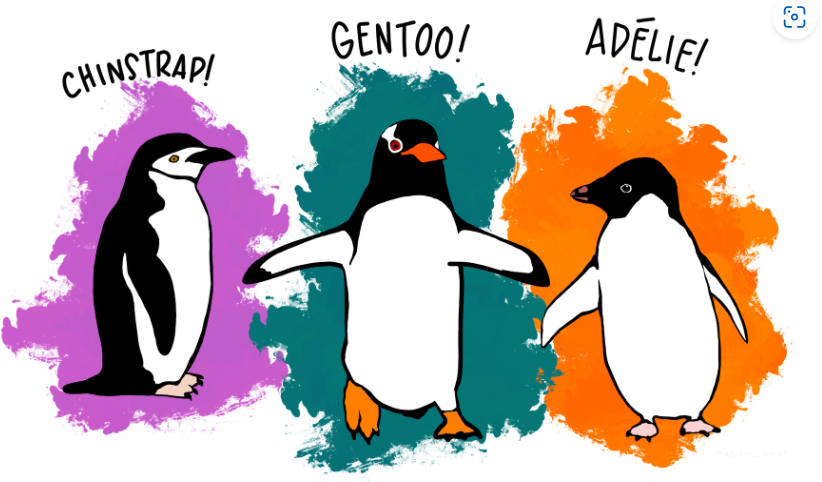

[Artwork by [@allison_horst](https://github.com/allisonhorst)]

The ***Penguins dataset*** comes from a [study by Gorman et al.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081) that examined the ecological and morphological characteristics of three penguin species in the Palmer Archipelago, Antarctica. It is the simplified version of the raw data and it contains 344 observations and 7 variables, that include the measurements of various physical attributes of penguins along other relevant charcteristics: <br>

- *Numerical variables*<br>
`bill length` (mm), `bill depth` (mm), `flipper length` (mm),`body mass`(g)

- *Categorical variables*<br>
`species` , `sex` of each penguin and the `island` where they belong.<br>

The dataset will be used to perform ***multi-class classification***, where the goal is to predict the species of a penguin based on its physical measurements and the other available characteristics.<br>

The dataset is available in the *Seaborn library* and documented in the [Palmer Penguins GitHub Repository](https://github.com/allisonhorst/palmerpenguins).








✅ **Completion requirement**: Show me the model trains as expected (e.g., loss, accuracy). It would be nice to visualize the activation functions before and after training.

In [ ]:
# TODO: complete Exercise 4.

#Base libraries
import seaborn as sns
import numpy as np
#jax and jax numpy are already imported at the beginning of the notebook

#Visualization
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#prepare the dataset for training and testing + compatibility with jax
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [ ]:
penguins = sns.load_dataset("penguins")

Let's have a look at our dataset to see how and if we need to preprocess it:

In [ ]:
#Let's look at some data to have an idea at how the datset is structured
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [ ]:
#Let's check for missing values
missing_rows = penguins[penguins.isna().any(axis=1)]
print("Rows with missing values:", missing_rows)
print(f"Number of rows with missing values: {missing_rows.shape[0]}")

Rows with missing values:     species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
3    Adelie  Torgersen             NaN            NaN                NaN   
8    Adelie  Torgersen            34.1           18.1              193.0   
9    Adelie  Torgersen            42.0           20.2              190.0   
10   Adelie  Torgersen            37.8           17.1              186.0   
11   Adelie  Torgersen            37.8           17.3              180.0   
47   Adelie      Dream            37.5           18.9              179.0   
246  Gentoo     Biscoe            44.5           14.3              216.0   
286  Gentoo     Biscoe            46.2           14.4              214.0   
324  Gentoo     Biscoe            47.3           13.8              216.0   
336  Gentoo     Biscoe            44.5           15.7              217.0   
339  Gentoo     Biscoe             NaN            NaN                NaN   

     body_mass_g  sex  
3            NaN  NaN  
8         347

In [ ]:
#Let's see the dimentions of our dataset
print("Penguins dataset dimentions:", penguins.shape)

Penguins dataset dimentions: (344, 7)


> We can see that it's not a very big dataset but we need to make some adjustments:<br>
1. Delete the rows with NaN values as they are only 11 over the whole 344 total rows, and it's generally not reccomended to keep NaN in the dataset.<br>
2. Encode the non-numerical variables `species`, `island`, `sex`.<br>
3. Standardize the numerical variables, because they have significant different scales and the MLP relies on gradient-based optimization which is sentitive to the scale of the input features.

***Delete NaN values***

In [ ]:
#Deleting NaN values
print(f"Number of rows before removing missing values: {penguins.shape[0]}")
penguins = penguins.dropna()
print(f"Number of rows after removing missing values: {penguins.shape[0]}")

Number of rows before removing missing values: 344
Number of rows after removing missing values: 333


***Encode the non-numerical variables***

In [ ]:
#To decide how to encode the non-numerical variables we first have a look at how many categories we have:
print("penguins islands", penguins["island"].unique())
print("penguins species", penguins["species"].unique())
print("sex of the penguins", penguins["sex"].unique())

penguins islands ['Torgersen' 'Biscoe' 'Dream']
penguins species ['Adelie' 'Chinstrap' 'Gentoo']
sex of the penguins ['Male' 'Female']


> We can see that we can easly use a map to encode this variables:

In [ ]:
label_encoder_species = LabelEncoder()
label_encoder_island = LabelEncoder()

penguins["species"] = label_encoder_species.fit_transform(penguins["species"])
penguins["island"] = label_encoder_island.fit_transform(penguins["island"])
penguins["sex"] = penguins["sex"].map({'Male': 0, 'Female': 1})

#Let's print island and species mappings to understand the encodings
print("Species mapping:", dict(zip(label_encoder_species.classes_, range(len(label_encoder_species.classes_)))))
print("Island mapping:", dict(zip(label_encoder_island.classes_, range(len(label_encoder_island.classes_)))))

Species mapping: {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
Island mapping: {'Biscoe': 0, 'Dream': 1, 'Torgersen': 2}


<ipython-input-140-01f0c6224587>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins["species"] = label_encoder_species.fit_transform(penguins["species"])
<ipython-input-140-01f0c6224587>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins["island"] = label_encoder_island.fit_transform(penguins["island"])
<ipython-input-140-01f0c6224587>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,0
1,0,2,39.5,17.4,186.0,3800.0,1
2,0,2,40.3,18.0,195.0,3250.0,1
4,0,2,36.7,19.3,193.0,3450.0,1
5,0,2,39.3,20.6,190.0,3650.0,0
6,0,2,38.9,17.8,181.0,3625.0,1
7,0,2,39.2,19.6,195.0,4675.0,0
12,0,2,41.1,17.6,182.0,3200.0,1
13,0,2,38.6,21.2,191.0,3800.0,0
14,0,2,34.6,21.1,198.0,4400.0,0


> Now we have our mapped dataset with only numerical variables

***Standardize***

In [ ]:
#Features to standardize
features_to_scale = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

scaler = StandardScaler()
penguins[features_to_scale] = scaler.fit_transform(penguins[features_to_scale])
print(penguins.head())

   species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0        0       2       -0.896042       0.780732          -1.426752   
1        0       2       -0.822788       0.119584          -1.069474   
2        0       2       -0.676280       0.424729          -0.426373   
4        0       2       -1.335566       1.085877          -0.569284   
5        0       2       -0.859415       1.747026          -0.783651   

   body_mass_g  sex  
0    -0.568475    0  
1    -0.506286    1  
2    -1.190361    1  
4    -0.941606    1  
5    -0.692852    0  


<ipython-input-142-d45f0547e020>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins[features_to_scale] = scaler.fit_transform(penguins[features_to_scale])


### **Model making**

In [ ]:
#Let's split the dataset for training and testing
X = penguins.drop(columns=["species"]).values  #features
y = penguins["species"].values  #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#stratify is needed as the target is not binary but has 3 classes


#Let's get a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)


In [ ]:
# Check if they are Numpy arrays before passing them to the tf.data:Dataset

print("Is X a NumPy array?", isinstance(X, np.ndarray))
print("Is y a NumPy array?", isinstance(y, np.ndarray))

print("Is X_train a NumPy array?", isinstance(X_train, np.ndarray))
print("Is X_test a NumPy array?", isinstance(X_test, np.ndarray))
print("Is X_val a NumPy array?", isinstance(X_val, np.ndarray))
print("Is y_train a NumPy array?", isinstance(y_train, np.ndarray))
print("Is y_test a NumPy array?", isinstance(y_test, np.ndarray))
print("Is y_val a NumPy array?", isinstance(y_val, np.ndarray))

Is X a NumPy array? True
Is y a NumPy array? True
Is X_train a NumPy array? True
Is X_test a NumPy array? True
Is X_val a NumPy array? True
Is y_train a NumPy array? True
Is y_test a NumPy array? True
Is y_val a NumPy array? True


In [ ]:
#Let's convert train, test and validation data to TensorFlow datasets to use the code seen in class
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#Create loaders
train_loader = (train_dataset.shuffle(buffer_size=1000).batch(64))
val_loader = val_dataset.batch(64)
test_loader = test_dataset.batch(64) #for the test and validation there's no need to shuffle

In [ ]:
#Let's test the loaders
for xb, yb in train_loader:
    xb = jnp.array(xb)
    yb = jnp.array(yb)
    print("Feature batch shape:", xb.shape)  # Should be (batch_size, num_features = 6)
    print("Label batch shape:", yb.shape)    # Should be (batch_size,)
    break

Feature batch shape: (64, 6)
Label batch shape: (64,)


> output as expected

#### **MLP Pipeline**

In [ ]:
#Initializing functions parameters

def init_dense_layers(key, input_dim, hidden_units, output_dim):
    """
        input_dim: Dimensionality of the input features.
        hidden_units: Number of units in the first dense layer.
        output_dim: Number of units in the output layer.
    """
    key1, key2 = jax.random.split(key,2)

    #first Dense layer parameters
    dense1_w = jax.random.normal(key1, (input_dim, hidden_units)) * jnp.sqrt(2.0 / input_dim) #weights
    #here we use He initialization (used for ReLu or similar activation functions) where the scaling factor "jnp.sqrt(2.0 / input_dim)" is based on the number of units
    #in the previous layer
    dense1_b = jnp.zeros((hidden_units,)) #bias

    #second Dense layer parameters
    dense2_w = jax.random.normal(key2, (hidden_units, output_dim)) * jnp.sqrt(2.0 / hidden_units) #weights
    dense2_b = jnp.zeros((output_dim,)) #bias

    return [dense1_w, dense1_b, dense2_w, dense2_b]


def init_swish_parameters(key, swish_dim, hidden_units):
    swish_a, swish_b, swish_c, swish_d = init_fcn_new(key, swish_dim, hidden_units)

    return [swish_a, swish_b, swish_c, swish_d]

In [ ]:
#Values for parameters intialization (based on penguin datset characteristics)
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]  #set input_dim dynamically
hidden_units = 36  #also try with 8 or 32, 20
output_dim = 3  #penguins has 3 classes (species)
swish_dim = 10
n = 10

In [ ]:
dense_key, swish_key = jax.random.split(key, 2)

dense_params = init_dense_layers(dense_key, input_dim, hidden_units, output_dim)
swish_params = init_swish_parameters(swish_key, swish_dim, hidden_units)
trainable_params = dense_params + swish_params

#check if the shapes of my tranable variables are consistent:
for i, var in enumerate(trainable_params):
    print(f"Parameter {i+1} shape: {var.shape}")

Parameter 1 shape: (6, 36)
Parameter 2 shape: (36,)
Parameter 3 shape: (36, 3)
Parameter 4 shape: (3,)
Parameter 5 shape: (10, 36)
Parameter 6 shape: (10, 36)
Parameter 7 shape: (10, 36)
Parameter 8 shape: (10, 36)


In [ ]:
trainable_variables = jax.tree_util.tree_map(lambda x: x, trainable_params)

In [ ]:
# Forward pass function
def forward_pass(trainable_variables, xb):
    dense1_w, dense1_b, dense2_w, dense2_b = trainable_variables[:4]
    swish_a, swish_b, swish_c, swish_d = trainable_variables[4:]

    swish_params = (swish_a, swish_b, swish_c, swish_d)

    #First dense layer
    x = jnp.dot(xb, dense1_w) + dense1_b

    #Middle layer
    x = vmapped_call_fcn_individual(swish_params, x)

    #Second dense layer (output layer)
    x = jnp.dot(x, dense2_w) + dense2_b

    #softmax for multiclass classification
    return jax.nn.softmax(x, axis=-1)

In [ ]:
#Let's use categorical cross-entropy loss because of multiclass classification of penguins species
def cross_entropy_loss(y_true, y_pred):
    y_true_one_hot = jax.nn.one_hot(y_true, num_classes=3)
    return -jnp.sum(y_true_one_hot * jnp.log(y_pred + 1e-7)) / y_true.shape[0]

def accuracy_fn(y_true, y_pred):
    predicted_class = jnp.argmax(y_pred, axis=1)
    return jnp.mean(predicted_class == y_true)

@jax.jit
@jax.value_and_grad
def loss_fn(trainable_variables, xb, yb):
    xb = jnp.array(xb)
    yb = jnp.array(yb)
    #forward pass to get predictions
    y_pred = forward_pass(trainable_variables, xb)
    #compute cross-entropy loss for multiclass classification
    return cross_entropy_loss(yb, y_pred)

In [ ]:
#Check the loss value before training
loss_value, gradients = loss_fn(trainable_variables, xb, yb)
print("Loss before training:", loss_value)

Loss before training: 0.47429287


***Plot of the Activation Function before training:***

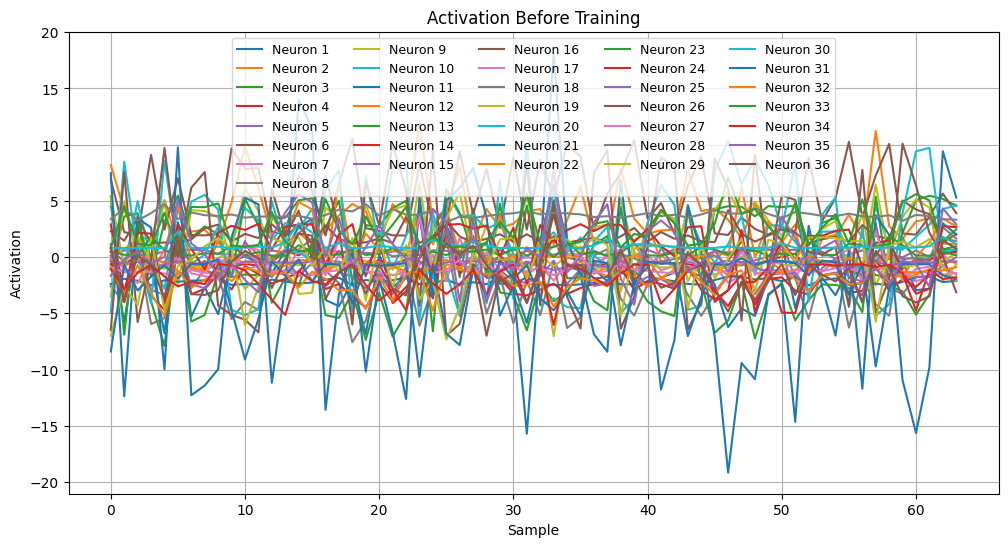

In [ ]:
#Extract hidden layer activations
def forward_pass_with_hidden(trainable_variables, xb):
    dense1_w, dense1_b, dense2_w, dense2_b = trainable_variables[:4]
    swish_a, swish_b, swish_c, swish_d = trainable_variables[4:]
    swish_params = (swish_a, swish_b, swish_c, swish_d)

    #First dense layer
    x = jnp.dot(xb, dense1_w) + dense1_b

    #Hidden layer
    hidden_activations = vmapped_call_fcn_individual(swish_params, x)

    #Second dense layer (output layer)
    output = jnp.dot(hidden_activations, dense2_w) + dense2_b

    #softmax for multiclass classification
    output = jax.nn.softmax(output, axis=-1)

    return output, hidden_activations  #output and hidden activations

_, initial_activations = forward_pass_with_hidden(trainable_variables, xb)

plt.figure(figsize=(12, 6))

for neuron_idx in range(initial_activations.shape[1]):
    plt.plot(initial_activations[:, neuron_idx], label=f'Neuron {neuron_idx + 1}')
plt.title('Activation Before Training')
plt.xlabel('Sample')
plt.ylabel('Activation')
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, fontsize=9, frameon=True
)
plt.grid()

plt.show()

> Here we can see an expected behaviour of the Activation Functions before training : the chaotic activations suggest that the network is still in its initial state, with no meaningful learning yet.

### **Training and Validation**

In [ ]:
def train_model_with_validation(trainable_variables, train_loader, val_loader, epochs, learning_rate):
    #loss and accuracy history for training and validation
    loss_history = []
    accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        num_batches = 0

        #training
        for xb, yb in train_loader:
            xb = jnp.array(xb)
            yb = jnp.array(yb)

            loss_value, gradients = loss_fn(trainable_variables, xb, yb)
            epoch_loss += loss_value

            #update parameters
            trainable_variables = jax.tree_util.tree_map(
                lambda p, g: p - learning_rate * g, trainable_variables, gradients
            )

            y_pred = forward_pass(trainable_variables, xb)
            batch_accuracy = accuracy_fn(yb, y_pred)
            epoch_accuracy += batch_accuracy
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        avg_accuracy = epoch_accuracy / num_batches
        loss_history.append(avg_loss)
        accuracy_history.append(avg_accuracy)

        #validation
        val_loss = 0
        val_accuracy = 0
        val_batches = 0

        for xb_val, yb_val in val_loader:
            xb_val = jnp.array(xb_val)
            yb_val = jnp.array(yb_val)

            val_loss += loss_fn(trainable_variables, xb_val, yb_val)[0]
            val_y_pred = forward_pass(trainable_variables, xb_val)
            val_accuracy += accuracy_fn(yb_val, val_y_pred)
            val_batches += 1

        avg_val_loss = val_loss / val_batches
        avg_val_accuracy = val_accuracy / val_batches
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_accuracy)

        # Print only every 20 epochs
        if (epoch + 1) % 20 == 0 or epoch == epochs - 1:  # Also print at the last epoch
            print(
                f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}"
            )
    return trainable_variables, loss_history, accuracy_history, val_loss_history, val_accuracy_history

In [ ]:
epochs = 100
learning_rate = 0.001

trainable_variables, train_loss, train_acc, val_loss, val_acc = train_model_with_validation(
    trainable_variables, train_loader, val_loader, epochs, learning_rate
)

Epoch 20, Loss: 0.2660, Accuracy: 0.8985, Val Loss: 0.3427, Val Accuracy: 0.8542
Epoch 40, Loss: 0.1420, Accuracy: 0.9445, Val Loss: 0.2414, Val Accuracy: 0.8620
Epoch 60, Loss: 0.1004, Accuracy: 0.9740, Val Loss: 0.1891, Val Accuracy: 0.8776
Epoch 80, Loss: 0.0857, Accuracy: 0.9749, Val Loss: 0.1592, Val Accuracy: 0.9453
Epoch 100, Loss: 0.0736, Accuracy: 0.9801, Val Loss: 0.1422, Val Accuracy: 0.9453


-----------------------------------------
Plotting ***Train and Validation loss***

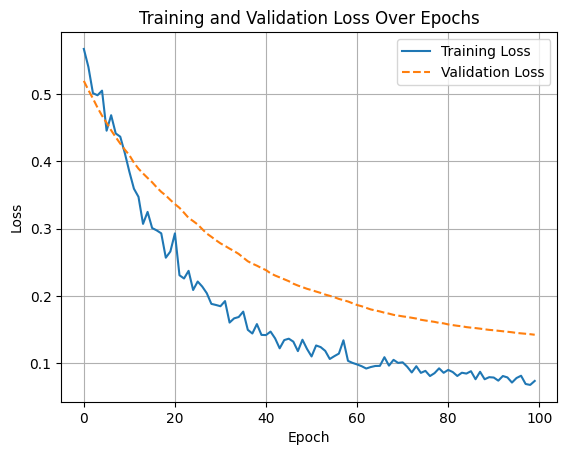

In [ ]:
#Loss
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

plt.legend()
plt.grid()
plt.show()

Plotting ***Train and Validation accuracy***

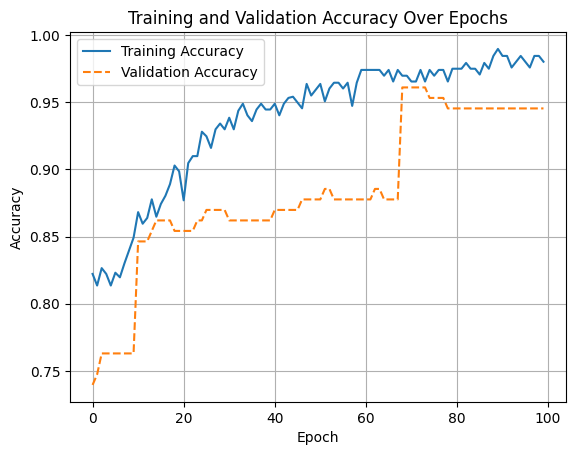

In [ ]:
#Accuracy
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")

plt.legend()
plt.grid()
plt.show()

#### **Parameter fine tuning**

Since the first parameter values used to train the MLP didn't yeild good results I tried some other values combination. By analyzing the loss and accuracy plots of training, validation and testing I found a good combination that gave me reasonable plots:

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 16
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 500
learning_rate = 0.001
```
--------------------------------------------------------------------------------



***1st try with the following values***

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 36  
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 100
learning_rate = 0.001
```
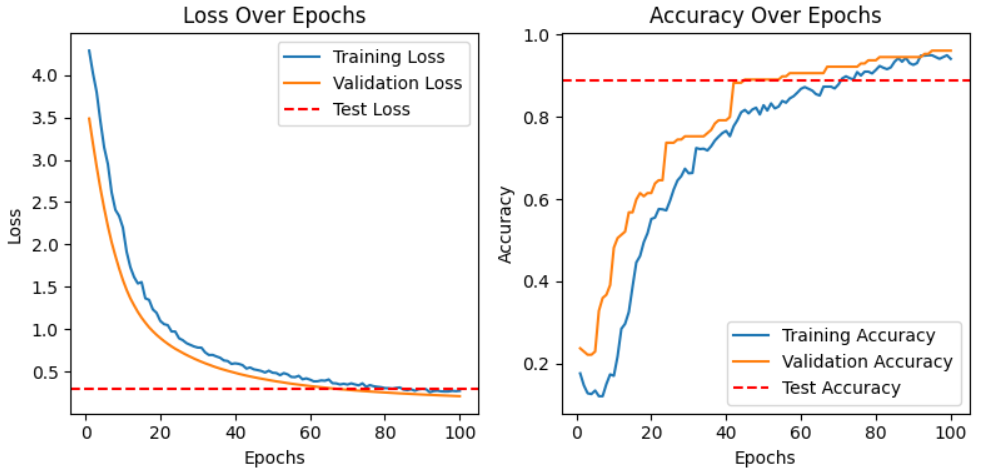

`Test Loss: 0.3986, Test Accuracy: 0.6898`

These plot might suggest:
- Overfitting
- Insufficient data (344 x 6)
- Validation set too small
- Too much hidden_units<br>
So Let's try first with smaller hidden_units and see if something changes:

***2nd try with the following values:***

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 16
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 100
learning_rate = 0.001
```
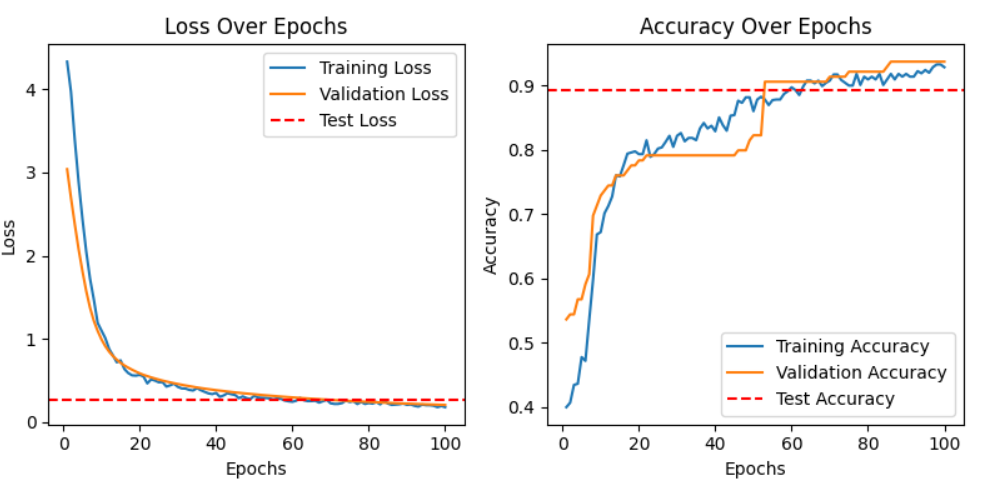

`Test Loss: 0.4450, Test Accuracy: 0.7839`

These plots indicate better generalization and reduced overfitting compared to the previous one with hidden units = 36. <br>The validation accuracy is closer to the training accuracy, and the test accuracy has slightly improved. However, in the current plot, hidden units = 16 might be limiting further improvement.<br> Further experimentation with hidden units between 16 and 36 could help achieve a better balance between capacity and generalization.:

***3rd try varying the hidden units***

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 20  
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 100
learning_rate = 0.001
```
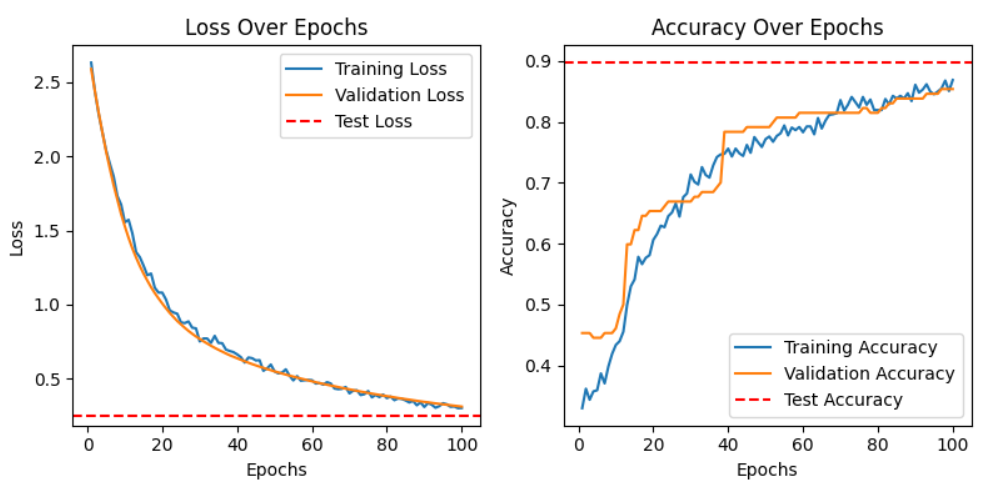

`Test Loss: 0.1822, Test Accuracy: 0.9470`

The new configuration shows improved performance, with a slightly higher Test Accuracy (0.8976 vs. 0.8941) and lower Test Loss (0.2525 vs. 0.2699) compared to the previous plot with hidden units = 16. The Training and Validation Loss curves track closely, and the accuracy curves converge smoothly, indicating minimal overfitting and better generalization. This suggests that increasing the hidden units slightly has enhanced the model's capacity while maintaining stability, so trying to tune the hidden_units seems the right path to choose.<br>
After some tries of combinations with swish_dim and hidden_units it seems like the best performance for this penguin dataset is given by swish_dim = 10 and hidden_units = 25 with number of epoch = 500:

***3rd try varying the number of epoch***

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 25  
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 200
learning_rate = 0.001
```

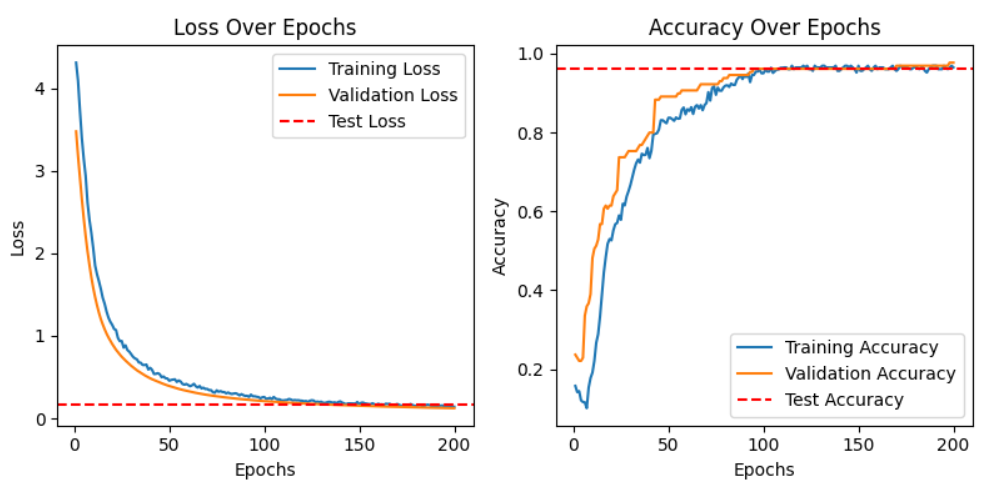

`Test Loss: 0.2733, Test Accuracy: 0.8819`

With hidden units = 25 and extending to 200 epochs, the model achieves a significant improvement, with a Test Accuracy of 0.9627 and Test Loss of 0.1739. The training and validation curves are closely aligned, indicating very good generalization and minimal overfitting. This configuration appears highly effective, striking a strong balance between capacity and performance.

***5th try varying the number of epoch***

```
key = jax.random.PRNGKey(0)
input_dim = xb.shape[1]
hidden_units = 25  
output_dim = 3  #penguins has 3 classes
swish_dim = 10  
n = 10

epochs = 500
learning_rate = 0.001
```


`Test Loss: 0.1499, Test Accuracy: 0.9505`

Extending training to 500 epochs has resulted in a significant improvement, with a Test Accuracy of 0.9783 and a reduced Test Loss of 0.0846. The Training and Validation Loss curves are nearly indistinguishable, and the Accuracy curves show convergence close to 1, indicating great generalization and no signs of overfitting.


--------------------------------------------------------------------------------
After training and validation the model we can proceed with testing:

#### ***Testing***

In [ ]:
def evaluate_model_on_test(test_loader, trainable_variables):
    test_loss = 0
    test_accuracy = 0
    num_batches = 0

    for xb_test, yb_test in test_loader:
        xb_test = jnp.array(xb_test)
        yb_test = jnp.array(yb_test)

        loss_value = loss_fn(trainable_variables, xb_test, yb_test)[0]
        test_loss += loss_value

        y_pred = forward_pass(trainable_variables, xb_test)
        test_accuracy += accuracy_fn(yb_test, y_pred)
        num_batches += 1

    avg_test_loss = test_loss / num_batches
    avg_test_accuracy = test_accuracy / num_batches

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")
    return avg_test_loss, avg_test_accuracy

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = evaluate_model_on_test(test_loader, trainable_variables)

Test Loss: 0.1120, Test Accuracy: 0.9627


Let's now plot the accuracy and loss for test, validation and training in one graph to have a general idea on how the model is going:

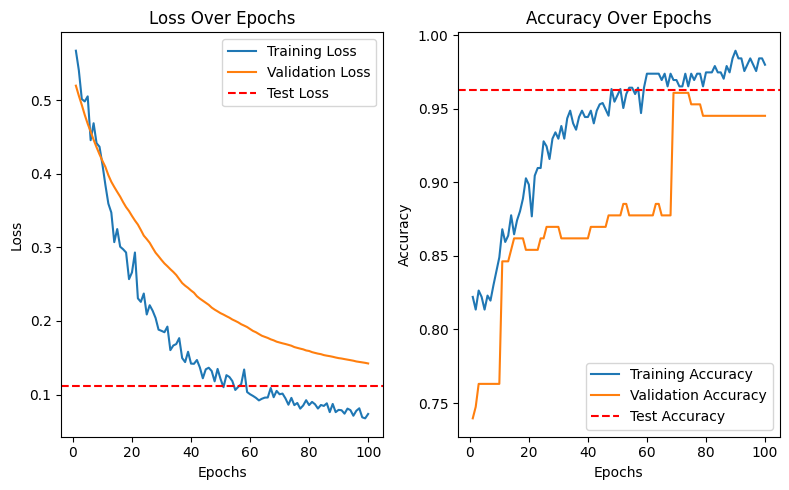

In [ ]:
def plot_training_validation_test(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, epochs):
    # Create a plot for loss
    plt.figure(figsize=(8, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss")
    plt.axhline(test_loss, color="red", linestyle="--", label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_acc, label="Training Accuracy")
    plt.plot(range(1, epochs + 1), val_acc, label="Validation Accuracy")
    plt.axhline(test_acc, color="red", linestyle="--", label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_training_validation_test(train_loss, val_loss, test_loss, train_acc, val_acc, test_accuracy, epochs)

Looking at the loss plot on the left, both the training and validation losses steadily decrease and converge without divergence, indicating effective learning and no overfitting. The validation loss closely tracks the training loss, demonstrating good generalization. Additionally, the test loss of 0.1499 is slightly lower than both the final training and validation losses, confirming the model's strong performance on unseen data.

Turning to the accuracy plot on the right, the training accuracy steadily increases and approaches 100%, showing that the model fits the training data effectively. The validation accuracy closely follows the training accuracy, stabilizing at a comparable level, which highlights the model's ability to generalize well. The test accuracy of 95.05% aligns closely with the validation accuracy, providing additional evidence of the model's robustness and generalization capability.

In summary, the model achieves excellent generalization, with minimal gaps between training, validation, and test metrics. The test accuracy of 95.05% and test loss of 0.1499 indicate that the model's predictions are both accurate and confident, making this configuration highly effective for the dataset.

***Plot of the Activation Functions before and after training :***

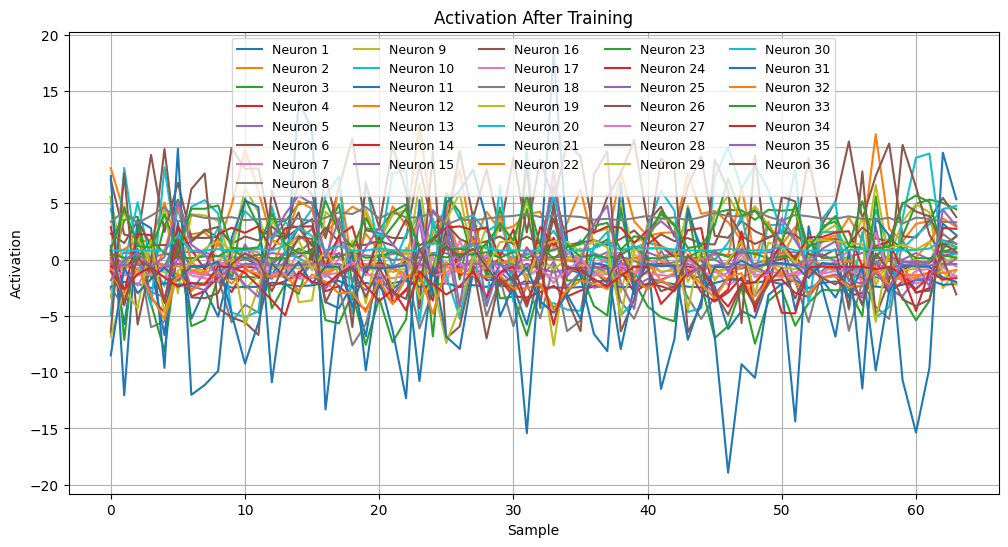

In [ ]:
#Activation after training
_, final_activations = forward_pass_with_hidden(trainable_variables, xb)

plt.figure(figsize=(12, 6))

for neuron_idx in range(final_activations.shape[1]):
    plt.plot(final_activations[:, neuron_idx], label=f'Neuron {neuron_idx + 1}')
plt.title("Activation After Training")
plt.xlabel("Sample")
plt.ylabel("Activation")
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, fontsize=9, frameon=True
)
plt.grid()

plt.show()

> We can see that the AF plot after the training is very similar to the one before teh training. Let's plot fewer neurons (let's say 5) to have a better look at what's happening:

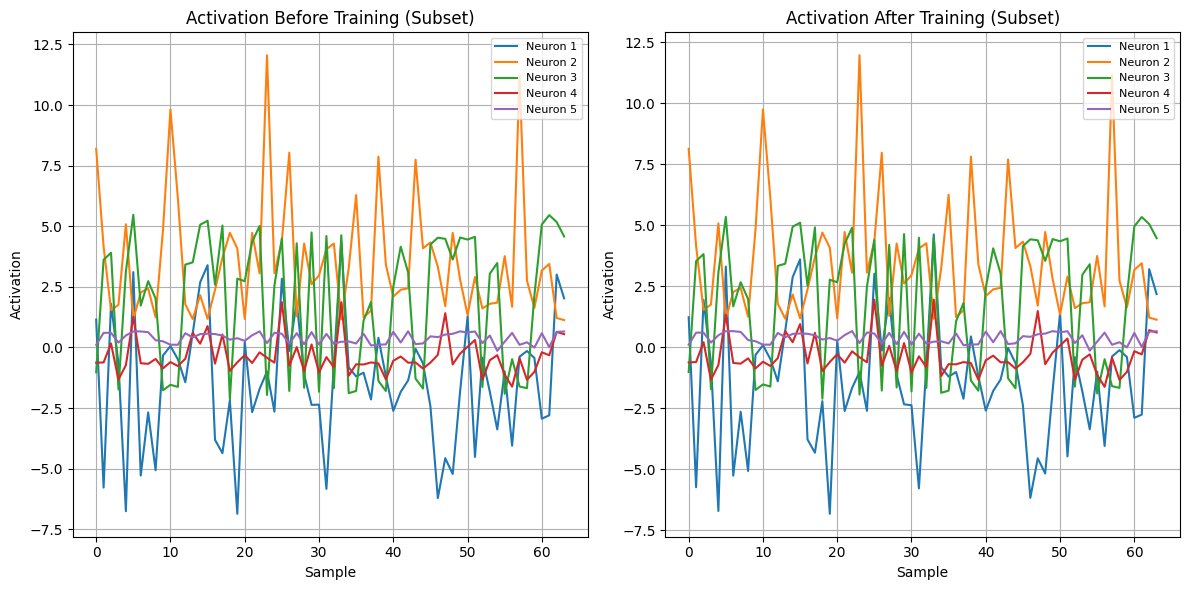

In [ ]:
subset_neurons = range(5)

plt.figure(figsize=(12, 6))

#before training
plt.subplot(1, 2, 1)
for neuron_idx in subset_neurons:
    plt.plot(initial_activations[:, neuron_idx], label=f'Neuron {neuron_idx + 1}')
plt.title("Activation Before Training (Subset)")
plt.xlabel("Sample")
plt.ylabel("Activation")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)

#after training
plt.subplot(1, 2, 2)
for neuron_idx in subset_neurons:
    plt.plot(final_activations[:, neuron_idx], label=f'Neuron {neuron_idx + 1}')
plt.title("Activation After Training (Subset)")
plt.xlabel("Sample")
plt.ylabel("Activation")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()

In the left plot the activations display a wide range of values with significant fluctuations across samples for each neuron. This unstructured behavior reflects the randomness of the initialized weights and biases before any learning occurs.<br>
After training (right plot), the overall scale and variability of activations remain similar, but some neurons show smoother and more consistent patterns, likely due to fine-tuning. <br> We can observe that Neurons like Neuron 2 and Neuron 5 still have pretty high variance, which might mean they're important for capturing the key features of the task.

This stability observed before and after the training might seem odd given the effective values of the loss and accuracy of the model, but it could be due to factors like saturated activations or well-aligned initialization.

Looking into how the weights are updating, how much each neuron is contributing, and whether adding regularization could help make the activations more diverse and effective might give a better idea of whether this stability means the model is learning well or if there's a problem.

### Exercise 5 (optional, ungraded)

It could happen that the model does not work as expected because the parameters of the AF collapse to some "weird" behaviour. We can partially solve this by imposing a **regularization** term on the loss that penalizes deviations from the initialization.

For example, suppose that CE is the cross-entropy loss, and we initialize our AFs as the ReLU. If we have a single AF for simplicity, we can penalize deviations from the initialization as:

$$ \arg\min \sum_z \text{CE}(y_z, \hat{y}_z) + \lambda \sum_{i} (\phi(s_i) - \text{ReLU}(s_i))^2 \tag{2} $$

where $z$ loops over the training dataset, $\lambda\ge 0$ is a hyper-parameter that balances the strength of the regularization, and $s_i$ are a set of points sampled on the x-axis (the more points we sample, the stronger the regularization). This can be extended trivially to multiple AFs by summing over the different functions.

For this exercise, modify the training from Exercise 4 by including a term as in (2) (not necessarily the same, it is enough that it has a similar effect).


✅ **Completion requirement**: Show me regularization works as expected (e.g., compare the trained AFs to those from Exercise 4).

In [ ]:
# TODO: complete exercise 5.

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 20/11/2024 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. A survey on modern trainable activation functions. Neural Networks, 138, pp. 14-32.

[2] Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., Hou, T.Y. and Tegmark, M., 2024. KAN: Kolmogorov-Arnold networks. arXiv preprint arXiv:2404.19756.